In [89]:
import numpy as np; import pandas as pd; import pyodbc; import datetime; import sklearn; import os; import math
from sklearn.feature_selection import chi2, f_classif, SelectKBest
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import roc_auc_score
from sklearn import preprocessing
import xgboost as xgb
from sklearn.cross_validation import StratifiedKFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn import metrics
from sklearn.random_projection import GaussianRandomProjection
from sklearn.random_projection import SparseRandomProjection
from sklearn.decomposition import PCA, FastICA
from sklearn.decomposition import TruncatedSVD
%pylab inline 
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")
    
from IPython.core.display import display,HTML
display(HTML("<style>.container{width:90% !important;}</style>"))

conn = pyodbc.connect(r'DRIVER={SQL Server Native Client 11.0};'r'SERVER=WIN-5G5AUOCEJPK;'r'DATABASE=Gold585;'r'Trusted_Connection=yes;')

Populating the interactive namespace from numpy and matplotlib


In [173]:
sql_query ="SELECT [PurchaseDate] \
      ,MONTH(GETDATE()) MesPrognoza\
      ,[PartnerID] \
      ,IIF(DATEDIFF(YEAR,[BirthDate],GETDATE())> 100 , 0 , DATEDIFF(YEAR,[BirthDate],GETDATE())) Age \
      ,IIF(SEX='M',1,0) SEX \
      ,CityID \
      ,SMS \
      ,SUMSMS \
      ,SumQuantity \
      ,[PurchaseCode] \
      ,[SummaAfterDiscount] \
      ,[FirstVisit] \
      ,DATEDIFF(DAY,[FirstVisit],GETDATE())/30.0 LT_M \
      ,DATEDIFF(DAY,[FirstVisit],GETDATE())/30.0 LastVisit_M \
      ,[NEXTDate] \
      ,DATEDIFF(DAY,GETDATE(),NEXTDate) PridetCherez \
      ,IIF(DATEDIFF(DAY,GETDATE(),NEXTDate)<=31,1,0) PridetCherez_M \
      ,IIF(NEXTDate IS NULL,1,0) Ottok \
      ,[GodNazad] \
      ,[QNTVisits] \
      ,[SUMM1] \
      ,[SUMM2] \
      ,[SUMM3] \
      ,[SUMM4] \
      ,[SUMM5] \
      ,[SUMM6] \
      ,[SUMM7] \
      ,[SUMM8] \
      ,[SUMM9] \
      ,[SUMM10] \
      ,[SUMM11] \
      ,[SUMM12] \
      ,[SumSumma] \
      ,[AVGSumma] \
      ,[SUMP1k] \
      ,[SUMP3k] \
      ,[SUMP6k] \
      ,[SUMP12k] \
      ,[SUMP50k] \
      ,[PriceGroup] \
      ,[MaterialID] \
      ,[Name] \
      ,[GroupID] \
      ,[CollectionID] \
      ,[SUMKolco] \
      ,[SUMSERGI] \
      ,[SUMPPODVES] \
      ,[SUMCEP] \
      ,[SUMBRASLET] \
      ,[SUMKOLE] \
      ,[WearType] \
      ,[SUMCheap] \
      ,[SUMExpensive] \
      ,[SUMPremium] \
      ,[SUMMiddle] \
      ,[PriceSegment] \
      ,[SUMZoloto] \
      ,[SUMSerebro] \
      ,[Metal] \
      ,[SUMColorBlack] \
      ,[SUMColorRed] \
      ,[SUMColorYellow] \
      ,[SUMColorWhite] \
      ,[SUMColor3] \
      ,[SUMColor2] \
      ,[MetalColor] \
      ,[SUMGroupBaza] \
      ,[SUMGroupClassic] \
      ,[SUMGroupModa] \
      ,[SUMGroupModul] \
      ,[SUMGroupSouvenir] \
      ,[SUMGroupTrend]  \
      ,[StylisticGroup] \
  FROM [Gold585].[dbo].[ForPredict] \
  WHERE [Metal] in ('ЗОЛОТО','СЕРЕБРО') and QNTVisits > 2"

df = pd.read_sql(sql_query,conn)

In [174]:
df.head()

,PurchaseDate,MesPrognoza,PartnerID,Age,SEX,CityID,SMS,SUMSMS,SumQuantity,PurchaseCode,...,SUMColor3,SUMColor2,MetalColor,SUMGroupBaza,SUMGroupClassic,SUMGroupModa,SUMGroupModul,SUMGroupSouvenir,SUMGroupTrend,StylisticGroup
0,2015-12-27,10,567512,30,1,92,0,0,5,1125499734,...,0,0,КРАСНЫЙ,1,4,0,0,0,0,КЛАССИКА
1,2018-09-01,10,572549,35,1,92,0,12,40,1217563616,...,0,0,КРАСНЫЙ,0,32,8,0,0,0,БАЗА
2,2016-03-01,10,2256871,0,0,90,0,0,6,1129516545,...,4,0,КРАСНЫЙ,2,4,0,0,0,0,КЛАССИКА
3,2018-05-09,10,593619,46,0,92,0,0,6,1209140210,...,0,0,БЕЛЫЙ,1,3,2,0,0,0,БАЗА
4,2015-03-06,10,1458477,24,0,115,0,0,84,1036396482,...,0,3,2ХЦВЕТН,21,60,0,0,0,0,КЛАССИКА


In [175]:
df.columns

Index(['PurchaseDate', 'MesPrognoza', 'PartnerID', 'Age', 'SEX', 'CityID',
       'SMS', 'SUMSMS', 'SumQuantity', 'PurchaseCode', 'SummaAfterDiscount',
       'FirstVisit', 'LT_M', 'LastVisit_M', 'NEXTDate', 'PridetCherez',
       'PridetCherez_M', 'Ottok', 'GodNazad', 'QNTVisits', 'SUMM1', 'SUMM2',
       'SUMM3', 'SUMM4', 'SUMM5', 'SUMM6', 'SUMM7', 'SUMM8', 'SUMM9', 'SUMM10',
       'SUMM11', 'SUMM12', 'SumSumma', 'AVGSumma', 'SUMP1k', 'SUMP3k',
       'SUMP6k', 'SUMP12k', 'SUMP50k', 'PriceGroup', 'MaterialID', 'Name',
       'GroupID', 'CollectionID', 'SUMKolco', 'SUMSERGI', 'SUMPPODVES',
       'SUMCEP', 'SUMBRASLET', 'SUMKOLE', 'WearType', 'SUMCheap',
       'SUMExpensive', 'SUMPremium', 'SUMMiddle', 'PriceSegment', 'SUMZoloto',
       'SUMSerebro', 'Metal', 'SUMColorBlack', 'SUMColorRed', 'SUMColorYellow',
       'SUMColorWhite', 'SUMColor3', 'SUMColor2', 'MetalColor', 'SUMGroupBaza',
       'SUMGroupClassic', 'SUMGroupModa', 'SUMGroupModul', 'SUMGroupSouvenir',
       'SUMGroupT

In [176]:
#Прогнозируем металл
data1 = df.copy()

In [177]:
data1.drop(['MesPrognoza','PurchaseDate','PurchaseCode','SummaAfterDiscount','FirstVisit','NEXTDate',
       'PridetCherez', 'PridetCherez_M', 'Ottok','PriceGroup', 'MaterialID',
       'Name', 'GroupID', 'CollectionID','WearType','PriceSegment', 'MetalColor','StylisticGroup'],axis=1,inplace=True)

In [178]:
data1.head()

,PartnerID,Age,SEX,CityID,SMS,SUMSMS,SumQuantity,LT_M,LastVisit_M,GodNazad,...,SUMColorYellow,SUMColorWhite,SUMColor3,SUMColor2,SUMGroupBaza,SUMGroupClassic,SUMGroupModa,SUMGroupModul,SUMGroupSouvenir,SUMGroupTrend
0,567512,30,1,92,0,0,5,66.100000,66.100000,0.0,...,0,0,0,0,1,4,0,0,0,0
1,572549,35,1,92,0,12,40,60.500000,60.500000,0.0,...,0,0,0,0,0,32,8,0,0,0
2,2256871,0,0,90,0,0,6,34.200000,34.200000,0.0,...,0,2,4,0,2,4,0,0,0,0
3,593619,46,0,92,0,0,6,22.200000,22.200000,0.0,...,0,6,0,0,1,3,2,0,0,0
4,1458477,24,0,115,0,0,84,46.366666,46.366666,0.0,...,0,3,0,3,21,60,0,0,0,0


In [179]:
data1.columns

Index(['PartnerID', 'Age', 'SEX', 'CityID', 'SMS', 'SUMSMS', 'SumQuantity',
       'LT_M', 'LastVisit_M', 'GodNazad', 'QNTVisits', 'SUMM1', 'SUMM2',
       'SUMM3', 'SUMM4', 'SUMM5', 'SUMM6', 'SUMM7', 'SUMM8', 'SUMM9', 'SUMM10',
       'SUMM11', 'SUMM12', 'SumSumma', 'AVGSumma', 'SUMP1k', 'SUMP3k',
       'SUMP6k', 'SUMP12k', 'SUMP50k', 'SUMKolco', 'SUMSERGI', 'SUMPPODVES',
       'SUMCEP', 'SUMBRASLET', 'SUMKOLE', 'SUMCheap', 'SUMExpensive',
       'SUMPremium', 'SUMMiddle', 'SUMZoloto', 'SUMSerebro', 'Metal',
       'SUMColorBlack', 'SUMColorRed', 'SUMColorYellow', 'SUMColorWhite',
       'SUMColor3', 'SUMColor2', 'SUMGroupBaza', 'SUMGroupClassic',
       'SUMGroupModa', 'SUMGroupModul', 'SUMGroupSouvenir', 'SUMGroupTrend'],
      dtype='object')

In [180]:
data1.describe()

,Age,SEX,CityID,SMS,SUMSMS,SumQuantity,LT_M,LastVisit_M,GodNazad,QNTVisits,...,SUMColorYellow,SUMColorWhite,SUMColor3,SUMColor2,SUMGroupBaza,SUMGroupClassic,SUMGroupModa,SUMGroupModul,SUMGroupSouvenir,SUMGroupTrend
count,2.120002e+06,2.120002e+06,2.120002e+06,2.120002e+06,2.120002e+06,2.120002e+06,2.120002e+06,2.120002e+06,2.094881e+06,2.120002e+06,...,2.120002e+06,2.120002e+06,2.120002e+06,2.120002e+06,2.120002e+06,2.120002e+06,2.120002e+06,2.120002e+06,2.120002e+06,2.120002e+06
mean,3.866967e+01,2.540752e-01,7.104584e+01,1.489848e-01,3.318987e+00,1.948183e+02,3.860953e+01,3.860953e+01,1.494825e-01,1.946720e+02,...,3.881916e-01,2.692868e+01,4.366689e-01,1.412290e+01,4.933680e+01,1.381567e+02,3.885524e+00,1.643934e+00,4.650510e-01,2.426101e-01
std,1.619384e+01,4.353402e-01,3.377768e+01,3.560735e-01,1.265798e+02,5.080544e+03,1.748818e+01,1.748818e+01,3.565635e-01,5.080118e+03,...,9.983399e+00,6.056525e+02,9.828585e+00,3.790246e+02,1.314535e+03,3.681113e+03,5.770013e+01,2.386816e+01,9.427608e+00,5.597139e+00
min,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,3.000000e+00,1.333330e-01,1.333330e-01,0.000000e+00,3.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.900000e+01,0.000000e+00,3.600000e+01,0.000000e+00,0.000000e+00,4.000000e+00,2.326667e+01,2.326667e+01,0.000000e+00,4.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,3.800000e+01,0.000000e+00,8.000000e+01,0.000000e+00,0.000000e+00,8.000000e+00,3.906667e+01,3.906667e+01,0.000000e+00,8.000000e+00,...,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,2.000000e+00,4.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,5.000000e+01,1.000000e+00,9.200000e+01,0.000000e+00,0.000000e+00,1.800000e+01,5.346667e+01,5.346667e+01,0.000000e+00,1.800000e+01,...,0.000000e+00,4.000000e+00,0.000000e+00,2.000000e+00,4.000000e+00,1.100000e+01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,1.000000e+02,1.000000e+00,1.280000e+02,1.000000e+00,1.470000e+04,3.705600e+05,7.056667e+01,7.056667e+01,1.000000e+00,3.705600e+05,...,7.680000e+02,4.339200e+04,7.680000e+02,2.880000e+04,9.715200e+04,2.674560e+05,3.456000e+03,1.536000e+03,5.760000e+02,5.500000e+02


In [181]:
data1.shape

(2120002, 55)

In [182]:
print(data1['QNTVisits'].quantile(0.95))
print(data1['SumSumma'].quantile(0.95))

126.0
638872.0000000001


In [183]:
data1 = data1[data1['QNTVisits']<126.0]
data1 = data1[data1['QNTVisits']<638872.0]

In [184]:
data1.shape

(2013940, 55)

In [185]:
data1['Metal'].replace('ЗОЛОТО' ,0,inplace=True)
data1['Metal'].replace('СЕРЕБРО',1,inplace=True)

In [186]:
data1['Metal'].value_counts()

0    1312681
1     701259
Name: Metal, dtype: int64

In [216]:
data = pd.get_dummies(data1, columns = ['SEX','CityID'],drop_first=True)

In [205]:
#feature engineering

In [206]:
#data= pd.concat([data,data[data['Metal']==1]],axis=0,ignore_index=True) # добавляем меньшего класса - делаем балансировку

In [207]:
%%time
n_comp = 5
data = data.fillna(0)
# tSVD
tsvd = TruncatedSVD(n_components=n_comp, random_state=420)
tsvd_results_train = tsvd.fit_transform(data.drop(["Metal",'PartnerID'], axis=1))
# PCA
pca = PCA(n_components=n_comp, random_state=420)
pca2_results_train = pca.fit_transform(data.drop(["Metal",'PartnerID'], axis=1))
# ICA
ica = FastICA(n_components=n_comp, random_state=420)
ica2_results_train = ica.fit_transform(data.drop(["Metal",'PartnerID'], axis=1))
# GRP
grp = GaussianRandomProjection(n_components=n_comp, eps=0.1, random_state=420)
grp_results_train = grp.fit_transform(data.drop(["Metal",'PartnerID'], axis=1))
# SRP
srp = SparseRandomProjection(n_components=n_comp, dense_output=True, random_state=420)
srp_results_train = srp.fit_transform(data.drop(["Metal",'PartnerID'], axis=1))

Wall time: 2min 17s


In [208]:
# Append decomposition components to datasets
for i in range(1, n_comp + 1):
    data['pca_' + str(i)] = pca2_results_train[:, i - 1]

    data['ica_' + str(i)] = ica2_results_train[:, i - 1]

    data['tsvd_' + str(i)] = tsvd_results_train[:, i - 1]

    data['grp_' + str(i)] = grp_results_train[:, i - 1]

    data['srp_' + str(i)] = srp_results_train[:, i - 1]
data.head()

,PartnerID,Age,SMS,SUMSMS,SumQuantity,LT_M,LastVisit_M,GodNazad,QNTVisits,SUMM1,...,pca_4,ica_4,tsvd_4,grp_4,srp_4,pca_5,ica_5,tsvd_5,grp_5,srp_5
0,567512,30,0,0,5,66.100000,66.100000,0.0,5,0,...,7.525243,-0.001199,23.072030,335.548107,10638.243471,-13.498367,0.000409,-20.175292,-14422.100263,-63.162850
1,572549,35,0,12,40,60.500000,60.500000,0.0,40,4,...,-15.201938,-0.001009,0.438910,25269.625492,6484.962183,-12.573303,-0.000399,-24.932579,-51996.003143,-183.010308
2,2256871,0,0,0,6,34.200000,34.200000,0.0,6,0,...,2.344599,0.000058,4.565296,1813.412338,12386.396807,-37.239086,0.000187,-29.533838,-19180.922133,-12.956482
3,593619,46,0,0,6,22.200000,22.200000,0.0,6,2,...,6.192477,0.000710,-5.918693,108.670079,1037.058415,11.919980,0.000152,21.347749,-1640.637653,-84.217133
4,1458477,24,0,0,84,46.366666,46.366666,0.0,81,21,...,-63.128498,-0.000594,-44.807614,45624.632167,5424.747056,-29.038318,-0.000941,-51.437111,-85860.615141,-276.944803


In [217]:
X = data.drop('Metal',axis=1).fillna(0)
y = data['Metal']

In [218]:
scaler = StandardScaler()
Xn = scaler.fit_transform(X)

In [219]:
Xn.shape

(2013940, 173)

In [220]:
y.shape

(2013940,)

In [221]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(Xn, y, test_size=0.25, random_state=42,stratify=y)

In [223]:
%%time
from sklearn import metrics
from sklearn.ensemble import ExtraTreesClassifier
# fit a CART model to the data
ExTC = ExtraTreesClassifier(n_jobs=-1,max_features='log2',class_weight='balanced',n_estimators=500 )
param_grid = { 
    'n_estimators': [50],
    'class_weight':['balanced'],
   # 'max_depth' : [2,200,1000],
    'max_features': ['auto', 'sqrt', 'log2']
}
model = GridSearchCV(estimator=ExTC, param_grid=param_grid, cv= 5)
model.fit(X_train, y_train)
#print(model)
# make predictions
expected = y_test
predicted = model.predict(X_test)
# summarize the fit of the model
print(metrics.classification_report(expected, predicted))
print(metrics.confusion_matrix(expected, predicted))
print(roc_auc_score(expected, predicted))
#ExtraTreesClassifier

             precision    recall  f1-score   support

          0       0.86      0.90      0.88    328170
          1       0.79      0.73      0.76    175315

avg / total       0.83      0.84      0.84    503485

[[294027  34143]
 [ 47968 127347]]
0.8111745263915885
Wall time: 23min 42s


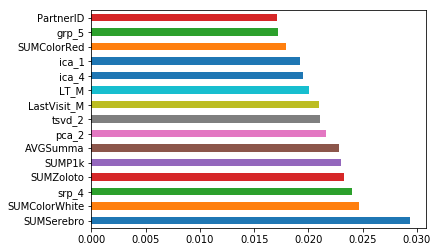

In [215]:
feat_importances = pd.Series(ExTC.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

In [144]:
from datetime import datetime
now = datetime.now()
print(now)

2018-10-19 11:29:07.393494


In [130]:
import xgboost as xgb

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)
# Setting some parameters

parameters = {
 #   'eta': 0.3,  
    'silent': True,  # option for logging
#    'objective': 'multi:softprob',  # error evaluation for multiclass tasks
    'num_class': 2  # number of classes to predic
#    ,'max_depth': 3  # depth of the trees in the boosting process
    }  
num_round = 200  # the number of training iterations
#training the model
bst = xgb.train(parameters, dtrain, num_round)
#resut
predicted = bst.predict(dtest)

print(metrics.classification_report(expected, predicted))
print(metrics.confusion_matrix(expected, predicted))
print(roc_auc_score(expected, predicted))

[18:45:32] Tree method is automatically selected to be 'approx' for faster speed. to use old behavior(exact greedy algorithm on single machine), set tree_method to 'exact'
             precision    recall  f1-score   support

          0       0.74      0.94      0.83   1145035
          1       0.68      0.29      0.41    525378

avg / total       0.72      0.73      0.70   1670413

[[1072449   72586]
 [ 370848  154530]]
0.6153695670227713


In [60]:
test_probs = model.predict_proba(X_test)[:,1]
print(roc_auc_score(y_test, test_probs))

0.8024974762560062


In [61]:
test_probs2 = model.predict(X_test)
print(roc_auc_score(y_test, test_probs2))

0.7103618934313884


In [21]:
%time
xgb_model = xgb.XGBClassifier()
parameters = {'nthread':[3,4,5],
              'objective':['binary:logistic'],
              'learning_rate':[0.01], 
              'max_depth': [10,12,14,20],
              'min_child_weight': [11],
              'silent': [1],
              'subsample': [0.7,0.8],
              'colsample_bytree': [0.6],
              'n_estimators': [50],
              'missing':[-9],
              'seed': [1337]}


clf = RandomizedSearchCV(xgb_model, parameters, n_jobs=30, 
                   cv=StratifiedKFold(y_train, n_folds=5, shuffle=True), 
                   scoring='roc_auc',
                   verbose=2, refit=True)
clf.fit(X_train, y_train)


best_parameters, score, _ = max(clf.grid_scores_, key=lambda x: x[1])
print('Raw AUC score:', score)
for param_name in sorted(best_parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))

# Проверка модели
test_probs = clf.predict_proba(X_test)[:,1]
print(roc_auc_score(y_test, test_probs))
test_probs2 = clf.predict(X_test)
print(roc_auc_score(y_test, test_probs2))

print(metrics.classification_report(y_test, test_probs2))
print(metrics.confusion_matrix(y_test, test_probs2))
print(roc_auc_score(y_test, test_probs2))

Wall time: 0 ns
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=30)]: Done  17 out of  50 | elapsed: 28.3min remaining: 54.9min
[Parallel(n_jobs=30)]: Done  43 out of  50 | elapsed: 49.3min remaining:  8.0min
[Parallel(n_jobs=30)]: Done  50 out of  50 | elapsed: 50.7min finished


Raw AUC score: 0.80788344703518
colsample_bytree: 0.6
learning_rate: 0.01
max_depth: 20
min_child_weight: 11
missing: -9
n_estimators: 50
nthread: 3
objective: 'binary:logistic'
seed: 1337
silent: 1
subsample: 0.8


NameError: name 'preds_class' is not defined

In [22]:
test_probs = clf.predict_proba(X_test)[:,1]
print(roc_auc_score(y_test, test_probs))
test_probs2 = clf.predict(X_test)
print(roc_auc_score(y_test, test_probs2))

print(metrics.classification_report(y_test, test_probs2))
print(metrics.confusion_matrix(y_test, test_probs2))
print(roc_auc_score(y_test, test_probs2))

0.811451160454299
0.7143896022004622
             precision    recall  f1-score   support

          0       0.79      0.90      0.84    412957
          1       0.73      0.53      0.61    215492

avg / total       0.77      0.77      0.76    628449

[[371379  41578]
 [101397 114095]]
0.7143896022004622


In [62]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(X_train, y_train)
print(reg.score(X, y))

-1.3996384402962994e+24


In [57]:
from catboost import CatBoostClassifier
from catboost import Pool

#cat_features = []
train_data = X_train
train_labels = y_train
test_data = X_test

p = Pool(X_train, y_train ) #,cat_features=cat_features)

model = CatBoostClassifier()#iterations=500, learning_rate=0.5, depth=10, loss_function='Logloss',silent=False)

model.fit(p)
# Прогноз класса
preds_class = model.predict(test_data)
# Прогноз вероятности каждого класса
preds_proba = model.predict_proba(test_data)

# Проверка модели
print(metrics.classification_report(y_test, preds_class))
print(metrics.confusion_matrix(y_test, preds_class))
print(roc_auc_score(y_test, preds_class))

Learning rate set to 0.132988
0:	learn: 0.6498896	total: 3.05s	remaining: 50m 49s
1:	learn: 0.6182309	total: 5.99s	remaining: 49m 46s
2:	learn: 0.5946717	total: 8.91s	remaining: 49m 21s
3:	learn: 0.5773377	total: 11.9s	remaining: 49m 16s
4:	learn: 0.5642877	total: 14.8s	remaining: 49m 13s
5:	learn: 0.5544349	total: 17.8s	remaining: 49m 16s
6:	learn: 0.5469088	total: 20.8s	remaining: 49m 12s
7:	learn: 0.5411687	total: 23.8s	remaining: 49m 9s
8:	learn: 0.5366285	total: 26.7s	remaining: 49m 4s
9:	learn: 0.5331064	total: 29.7s	remaining: 49m
10:	learn: 0.5303348	total: 32.6s	remaining: 48m 50s
11:	learn: 0.5281654	total: 35.5s	remaining: 48m 42s
12:	learn: 0.5264513	total: 38.4s	remaining: 48m 33s
13:	learn: 0.5250039	total: 41.3s	remaining: 48m 30s
14:	learn: 0.5238201	total: 44.3s	remaining: 48m 26s
15:	learn: 0.5228863	total: 47.2s	remaining: 48m 20s
16:	learn: 0.5221295	total: 50.1s	remaining: 48m 14s
17:	learn: 0.5214660	total: 53s	remaining: 48m 11s
18:	learn: 0.5208927	total: 55.9s	

153:	learn: 0.5091334	total: 7m 34s	remaining: 41m 39s
154:	learn: 0.5090813	total: 7m 37s	remaining: 41m 36s
155:	learn: 0.5090489	total: 7m 40s	remaining: 41m 33s
156:	learn: 0.5090136	total: 7m 43s	remaining: 41m 30s
157:	learn: 0.5089846	total: 7m 46s	remaining: 41m 27s
158:	learn: 0.5089624	total: 7m 49s	remaining: 41m 24s
159:	learn: 0.5089370	total: 7m 52s	remaining: 41m 22s
160:	learn: 0.5088990	total: 7m 55s	remaining: 41m 18s
161:	learn: 0.5088776	total: 7m 58s	remaining: 41m 15s
162:	learn: 0.5088491	total: 8m 1s	remaining: 41m 12s
163:	learn: 0.5088307	total: 8m 4s	remaining: 41m 9s
164:	learn: 0.5087789	total: 8m 7s	remaining: 41m 6s
165:	learn: 0.5087311	total: 8m 10s	remaining: 41m 3s
166:	learn: 0.5086856	total: 8m 13s	remaining: 41m
167:	learn: 0.5086523	total: 8m 16s	remaining: 40m 57s
168:	learn: 0.5086159	total: 8m 19s	remaining: 40m 55s
169:	learn: 0.5085754	total: 8m 22s	remaining: 40m 52s
170:	learn: 0.5085475	total: 8m 25s	remaining: 40m 49s
171:	learn: 0.508519

302:	learn: 0.5053520	total: 14m 55s	remaining: 34m 20s
303:	learn: 0.5053218	total: 14m 58s	remaining: 34m 17s
304:	learn: 0.5052947	total: 15m 1s	remaining: 34m 14s
305:	learn: 0.5052729	total: 15m 4s	remaining: 34m 11s
306:	learn: 0.5052537	total: 15m 7s	remaining: 34m 8s
307:	learn: 0.5052324	total: 15m 10s	remaining: 34m 5s
308:	learn: 0.5052146	total: 15m 13s	remaining: 34m 3s
309:	learn: 0.5051960	total: 15m 16s	remaining: 34m
310:	learn: 0.5051761	total: 15m 19s	remaining: 33m 57s
311:	learn: 0.5051476	total: 15m 22s	remaining: 33m 54s
312:	learn: 0.5051310	total: 15m 25s	remaining: 33m 51s
313:	learn: 0.5051063	total: 15m 28s	remaining: 33m 48s
314:	learn: 0.5050704	total: 15m 31s	remaining: 33m 45s
315:	learn: 0.5050542	total: 15m 34s	remaining: 33m 42s
316:	learn: 0.5050364	total: 15m 37s	remaining: 33m 39s
317:	learn: 0.5050185	total: 15m 40s	remaining: 33m 36s
318:	learn: 0.5050039	total: 15m 43s	remaining: 33m 33s
319:	learn: 0.5049779	total: 15m 46s	remaining: 33m 30s
32

450:	learn: 0.5026322	total: 22m 12s	remaining: 27m 2s
451:	learn: 0.5026154	total: 22m 15s	remaining: 26m 59s
452:	learn: 0.5025962	total: 22m 18s	remaining: 26m 56s
453:	learn: 0.5025857	total: 22m 21s	remaining: 26m 53s
454:	learn: 0.5025726	total: 22m 24s	remaining: 26m 50s
455:	learn: 0.5025618	total: 22m 27s	remaining: 26m 47s
456:	learn: 0.5025501	total: 22m 30s	remaining: 26m 44s
457:	learn: 0.5025402	total: 22m 33s	remaining: 26m 42s
458:	learn: 0.5025227	total: 22m 36s	remaining: 26m 39s
459:	learn: 0.5025045	total: 22m 39s	remaining: 26m 36s
460:	learn: 0.5024849	total: 22m 42s	remaining: 26m 33s
461:	learn: 0.5024724	total: 22m 45s	remaining: 26m 30s
462:	learn: 0.5024543	total: 22m 48s	remaining: 26m 27s
463:	learn: 0.5024464	total: 22m 51s	remaining: 26m 24s
464:	learn: 0.5024219	total: 22m 54s	remaining: 26m 21s
465:	learn: 0.5024066	total: 22m 57s	remaining: 26m 18s
466:	learn: 0.5023907	total: 23m	remaining: 26m 15s
467:	learn: 0.5023711	total: 23m 3s	remaining: 26m 12

598:	learn: 0.5004882	total: 29m 31s	remaining: 19m 46s
599:	learn: 0.5004778	total: 29m 34s	remaining: 19m 43s
600:	learn: 0.5004624	total: 29m 37s	remaining: 19m 40s
601:	learn: 0.5004462	total: 29m 40s	remaining: 19m 37s
602:	learn: 0.5004262	total: 29m 43s	remaining: 19m 34s
603:	learn: 0.5004131	total: 29m 46s	remaining: 19m 31s
604:	learn: 0.5003973	total: 29m 49s	remaining: 19m 28s
605:	learn: 0.5003826	total: 29m 52s	remaining: 19m 25s
606:	learn: 0.5003596	total: 29m 55s	remaining: 19m 22s
607:	learn: 0.5003419	total: 29m 58s	remaining: 19m 19s
608:	learn: 0.5003197	total: 30m 1s	remaining: 19m 16s
609:	learn: 0.5003152	total: 30m 4s	remaining: 19m 13s
610:	learn: 0.5003044	total: 30m 7s	remaining: 19m 10s
611:	learn: 0.5002941	total: 30m 10s	remaining: 19m 7s
612:	learn: 0.5002884	total: 30m 13s	remaining: 19m 4s
613:	learn: 0.5002773	total: 30m 16s	remaining: 19m 1s
614:	learn: 0.5002609	total: 30m 19s	remaining: 18m 58s
615:	learn: 0.5002501	total: 30m 22s	remaining: 18m 55

746:	learn: 0.4984783	total: 36m 36s	remaining: 12m 23s
747:	learn: 0.4984662	total: 36m 39s	remaining: 12m 20s
748:	learn: 0.4984526	total: 36m 41s	remaining: 12m 17s
749:	learn: 0.4984429	total: 36m 44s	remaining: 12m 14s
750:	learn: 0.4984239	total: 36m 47s	remaining: 12m 11s
751:	learn: 0.4984084	total: 36m 50s	remaining: 12m 8s
752:	learn: 0.4983934	total: 36m 53s	remaining: 12m 5s
753:	learn: 0.4983849	total: 36m 56s	remaining: 12m 3s
754:	learn: 0.4983671	total: 36m 58s	remaining: 12m
755:	learn: 0.4983594	total: 37m 1s	remaining: 11m 57s
756:	learn: 0.4983455	total: 37m 4s	remaining: 11m 54s
757:	learn: 0.4983294	total: 37m 7s	remaining: 11m 51s
758:	learn: 0.4983155	total: 37m 9s	remaining: 11m 48s
759:	learn: 0.4983023	total: 37m 12s	remaining: 11m 45s
760:	learn: 0.4982835	total: 37m 15s	remaining: 11m 42s
761:	learn: 0.4982648	total: 37m 18s	remaining: 11m 39s
762:	learn: 0.4982548	total: 37m 21s	remaining: 11m 36s
763:	learn: 0.4982503	total: 37m 24s	remaining: 11m 33s
764

896:	learn: 0.4966361	total: 43m 39s	remaining: 5m
897:	learn: 0.4966270	total: 43m 42s	remaining: 4m 57s
898:	learn: 0.4966170	total: 43m 45s	remaining: 4m 54s
899:	learn: 0.4966077	total: 43m 48s	remaining: 4m 52s
900:	learn: 0.4965940	total: 43m 51s	remaining: 4m 49s
901:	learn: 0.4965839	total: 43m 53s	remaining: 4m 46s
902:	learn: 0.4965696	total: 43m 56s	remaining: 4m 43s
903:	learn: 0.4965603	total: 43m 59s	remaining: 4m 40s
904:	learn: 0.4965526	total: 44m 2s	remaining: 4m 37s
905:	learn: 0.4965395	total: 44m 5s	remaining: 4m 34s
906:	learn: 0.4965258	total: 44m 8s	remaining: 4m 31s
907:	learn: 0.4965075	total: 44m 11s	remaining: 4m 28s
908:	learn: 0.4964944	total: 44m 14s	remaining: 4m 25s
909:	learn: 0.4964822	total: 44m 17s	remaining: 4m 22s
910:	learn: 0.4964718	total: 44m 20s	remaining: 4m 19s
911:	learn: 0.4964531	total: 44m 23s	remaining: 4m 16s
912:	learn: 0.4964403	total: 44m 26s	remaining: 4m 14s
913:	learn: 0.4964292	total: 44m 29s	remaining: 4m 11s
914:	learn: 0.496

In [58]:
# Проверка модели
print(metrics.classification_report(y_test, preds_class))
print(metrics.confusion_matrix(y_test, preds_class))
print(roc_auc_score(y_test, preds_class))

             precision    recall  f1-score   support

          0       0.78      0.90      0.83    328170
          1       0.73      0.52      0.61    175315

avg / total       0.76      0.77      0.76    503485

[[294102  34068]
 [ 83356  91959]]
0.7103618934313884


In [63]:
test_probs2 = reg.predict(X_test)
print(roc_auc_score(y_test, test_probs2))

0.7618932491281364


In [24]:
test_probs2 = reg.predict(X_test)
print(roc_auc_score(y_test, test_probs2))

0.7522285871607588


In [64]:
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(X_train, y_train)
print(model)
# make predictions
expected = y_test
predicted = model.predict(X_test)
# summarize the fit of the model
print(metrics.classification_report(expected, predicted))
print(metrics.confusion_matrix(expected, predicted))

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
             precision    recall  f1-score   support

          0       0.76      0.90      0.83    328170
          1       0.72      0.48      0.57    175315

avg / total       0.75      0.75      0.74    503485

[[295351  32819]
 [ 91828  83487]]


In [65]:
test_probs2 = model.predict(X_test)
print(roc_auc_score(y_test, test_probs2))

0.6881026482613075


In [82]:
%%time
from sklearn import metrics
from sklearn.ensemble import GradientBoostingClassifier
model = GradientBoostingClassifier(n_)
model.fit(X_train, y_train)
#print(model)
# make predictions
expected = y_test
predicted = model.predict(X_test)
# summarize the fit of the model
print(metrics.classification_report(expected, predicted))
print(metrics.confusion_matrix(expected, predicted))
print(roc_auc_score(expected, predicted))

KeyboardInterrupt: 

In [66]:
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
# fit a CART model to the data
model = DecisionTreeClassifier()
model.fit(X_train, y_train)
#print(model)
# make predictions
expected = y_test
predicted = model.predict(X_test)
# summarize the fit of the model
print(metrics.classification_report(expected, predicted))
print(metrics.confusion_matrix(expected, predicted))
print(roc_auc_score(expected, predicted))
#ExtraTreesClassifier

             precision    recall  f1-score   support

          0       0.84      0.86      0.85    328170
          1       0.72      0.70      0.71    175315

avg / total       0.80      0.80      0.80    503485

[[280827  47343]
 [ 53209 122106]]
0.7761156184001416


In [87]:
model.best_estimator_

ExtraTreesClassifier(bootstrap=False, class_weight='balanced',
           criterion='gini', max_depth=None, max_features='log2',
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=700, n_jobs=-1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [30]:
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
# fit a CART model to the data
model = xgb.XGBClassifier()
model.fit(X_train, y_train)
#print(model)
# make predictions
expected = y_test
predicted = model.predict(X_test)
# summarize the fit of the model
print(metrics.classification_report(expected, predicted))
print(metrics.confusion_matrix(expected, predicted))
print(roc_auc_score(expected, predicted))

             precision    recall  f1-score   support

          0       0.78      0.89      0.83    412957
          1       0.70      0.51      0.59    215492

avg / total       0.75      0.76      0.75    628449

[[366628  46329]
 [105121 110371]]
0.6999964953022748


In [26]:
y_train.value_counts()

0    1238871
1     646473
Name: Metal, dtype: int64

In [27]:
%%time
from sklearn.linear_model import ElasticNetCV
model = ElasticNetCV()
model.fit(X_train, y_train)
#print(model)
# make predictions
expected = y_test
predicted = model.predict(X_test)

Wall time: 1min 24s


In [32]:
# summarize the fit of the model
#print(metrics.classification_report(expected, predicted))
#print(metrics.confusion_matrix(expected, predicted))
print(roc_auc_score(expected, predicted))

0.7517887180717764


In [ ]:
from sklearn import metrics
#from sklearn.neighbors import KNeighborsClassifier
# fit a CART model to the data
model = KNeighborsClassifier()
model.fit(X_train, y_train)
#print(model)
# make predictions
expected = y_test
predicted = model.predict(X_test)
# summarize the fit of the model
print(metrics.classification_report(expected, predicted))
print(metrics.confusion_matrix(expected, predicted))
print(roc_auc_score(expected, predicted))

In [1]:
2+2

4